In [439]:
import pandas as pd
import numpy as np

df_data = pd.read_csv("PWG Testing - Sheet1.csv")

colfixnames = df_data.loc[0,:]
colfixnames[:3] = df_data.columns[:3]
colfixnames['Whistle'] = 'Combo'
colfixnames['PWG Testing'] = 'Max Back Pressure in kPA'
df_data = df_data.rename(columns=colfixnames)
df_data = df_data.ix[1:]
df_data['Combo'] = df_data['Combo'].fillna(method='ffill')
# for col in ['Mouthpiece','Stack','Ball','DST']:
#     df_data[col] = pd.Series(np.zeros(len(df_data)), index=df_data.index)

for col in ['Test Time Begin','Test Time End','Minimum Time Vortex Audible','Maximum Time Vortex Audible']:
    df_data[col] = df_data[col].astype(np.float)
    
df_data.head()

,Combo,PWG File,Max Back Pressure in kPA,Time Difference between Ideal/Actual Max Flow,Difference between Ideal and Actual Max Flow Rate,Test Successfully Completed,Test Time Begin,Test Time End,Minimum Time Vortex Audible,Maximum Time Vortex Audible,Minimum Audible Vortex Frequency Begin,Minimum Audible Vortex Frequency End,Frequency at Max Flow,Minimum Time for Audible Side Whistle Start,Minimum Time for Audible Side Whistle End,Max Flow in Waveform File,Failed to Develop Vortex,Failed to Sound Side Whistle,Max Rise Time in Waveform File
1,DigiDoc1,Custom01,3.4,0.4,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,90
2,DigiDoc1,Custom02,3.4,0.4,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,70
3,DigiDoc1,Custom03,3.4,0.3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,50
4,DigiDoc1,Custom04,3.4,0.4,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,30
5,DigiDoc1,Custom05,3.4,0.25,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0,0,10


In [440]:
def extract_waveform_data(txtdata):
    data = []
    valid = False
    for line in txtdata:
        line = line.strip()
        if valid:
            data += [float(line)]
        elif not valid:
            if line.find("Data") != -1:
                valid = True
            elif line.find("Freq") != -1:
                tmp = line.split('=')
                fs = float(tmp[1])
    return data, fs
        
    
# add in the flow rates when the vortex is audible
flow_at_minimum = np.zeros(len(df_data))*np.nan
flow_at_maximum = np.zeros(len(df_data))*np.nan
for i,row in df_data.iterrows():
    t1 = row['Minimum Time Vortex Audible'] - row['Test Time Begin']
    t2 = row['Maximum Time Vortex Audible'] - row['Test Time Begin']
    if np.isfinite(t1) and np.isfinite(t2):
        filename = 'Waveform/'+str(row['PWG File'])+'.wf'
        with open(filename) as fid:
            txt = fid.readlines()
        data,fs = extract_waveform_data(txt)
        
        idx = int(fs*t1)-1
        flow_at_minimum[i] = data[idx]
        idx = int(fs*t2)-1
        if idx < len(data):
            flow_at_maximum[i] = data[idx]
        else:
            print 'possible transcription error for:', row
        
df_data['Minimum Flow for Audible Vortex Start'] = flow_at_minimum
df_data['Minimum Flow for Audible Vortex End'] = flow_at_maximum

In [441]:
df_combo = pd.read_csv("PWG Testing - Sheet2.csv")
colfixnames = df_combo.loc[0,:]
df_combo = df_combo.rename(columns=colfixnames)
df_combo = df_combo.ix[1:]
df_combo.head()

,Combo,Ball,Downstream Tube,Sidestack,Mouthpiece
1,Combo 1,A (Blue),A (Blue),A (Red),A (Red)
2,Combo 2,A (Blue),A (Blue),A (Red),B (Green)
3,Combo 3,A (Blue),A (Blue),A (Red),C (Yellow)
4,Combo 4,A (Blue),A (Blue),B (Green),A (Red)
5,Combo 5,A (Blue),A (Blue),B (Green),B (Green)


In [442]:
df_size = pd.read_csv("PWG Testing - Sheet3.csv")

df_combo = df_combo.merge(df_size[['Ball','Ball Infill']], on='Ball',how='left')
df_combo = df_combo.merge(df_size[['Downstream Tube','DST Length']], on='Downstream Tube',how='left')
df_combo = df_combo.merge(df_size[['Sidestack','SideStack Area']], on='Sidestack',how='left')
df_combo = df_combo.merge(df_size[['Mouthpiece','Mouthpiece Inlet Size']], on='Mouthpiece',how='left')

df_combo.head()

,Combo,Ball,Downstream Tube,Sidestack,Mouthpiece,Ball Infill,DST Length,SideStack Area,Mouthpiece Inlet Size
0,Combo 1,A (Blue),A (Blue),A (Red),A (Red),0,16,125.663706,45.00
1,Combo 2,A (Blue),A (Blue),A (Red),B (Green),0,16,125.663706,61.02
2,Combo 3,A (Blue),A (Blue),A (Red),C (Yellow),0,16,125.663706,108.45
3,Combo 4,A (Blue),A (Blue),B (Green),A (Red),0,16,251.327412,45.00
4,Combo 5,A (Blue),A (Blue),B (Green),B (Green),0,16,251.327412,61.02


In [443]:
df = df_data.merge(df_combo, on='Combo', how='right')
df.head() # the merged data frame

,Combo,PWG File,Max Back Pressure in kPA,Time Difference between Ideal/Actual Max Flow,Difference between Ideal and Actual Max Flow Rate,Test Successfully Completed,Test Time Begin,Test Time End,Minimum Time Vortex Audible,Maximum Time Vortex Audible,...,Minimum Flow for Audible Vortex Start,Minimum Flow for Audible Vortex End,Ball,Downstream Tube,Sidestack,Mouthpiece,Ball Infill,DST Length,SideStack Area,Mouthpiece Inlet Size
0,Combo 1,Custom01,1.1,0.12,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,A (Blue),A (Blue),A (Red),A (Red),0,16,125.663706,45
1,Combo 1,Custom02,1,0.12,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,A (Blue),A (Blue),A (Red),A (Red),0,16,125.663706,45
2,Combo 1,Custom03,1.1,0.1,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,A (Blue),A (Blue),A (Red),A (Red),0,16,125.663706,45
3,Combo 1,Custom04,1,0.1,NaN,1,NaN,NaN,NaN,NaN,...,NaN,NaN,A (Blue),A (Blue),A (Red),A (Red),0,16,125.663706,45
4,Combo 1,Custom05,1.8,0.08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,A (Blue),A (Blue),A (Red),A (Red),0,16,125.663706,45


In [444]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn import linear_model
import copy

def create_interaction_terms(frame):
    cols = frame.columns
    for i,x in enumerate(cols):
        for j,y in enumerate(cols[i:]):
            nme = x+'-'+y
            if j==0:
                frame[nme] = frame[x].values*frame[y].values
            else:
                frame[nme] = frame[x].values*frame[y].values
    return frame

def show_regression_equation(frame,reg_obj,score,thresh=0.2):
    print '---------------------------------'
    print 'Linear Estimator R^2 = '+str(score)+'  %d parameters'%((len(frame.columns)))
    best_cols = []
    w = reg_obj.coef_
    idxs = np.argsort(np.abs(w))
    vals = zip(w[idxs],frame.columns[idxs])
    print '(intrcpt)\t'+ str(reg_obj.intercept_)
    for wght,nme in vals:
        importance = np.abs(wght*np.abs(np.max(frame[nme])-np.min(frame[nme])))
        if importance > thresh:
            best_cols += [nme]
            print "(%.2f)\t\t%.9f*%s"%((importance,wght,nme))
    print '---------------------------------'
    return best_cols

reg_dict = dict()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432 entries, 0 to 431
Data columns (total 6 columns):
Ball Infill                  432 non-null float64
DST Length                   432 non-null float64
SideStack Area               432 non-null float64
Mouthpiece Inlet Size        432 non-null float64
Max Flow in Waveform File    432 non-null float64
Max Back Pressure in kPA     432 non-null float64
dtypes: float64(6)
memory usage: 23.6 KB
---------------------------------
Linear Estimator R^2 = 0.953263523869  20 parameters
(intrcpt)	-0.767458003151
(1.90)		-0.000472873*SideStack Area-Max Flow in Waveform File
(5.52)		0.046018339*Max Flow in Waveform File-Max Flow in Waveform File
(1.83)		0.152894274*DST Length
---------------------------------
---------------------------------
Linear Estimator R^2 = 0.946666893869  3 parameters
(intrcpt)	0.366223544821
(1.27)		-0.000314687*SideStack Area-Max Flow in Waveform File
(0.10)		-0.008229167*DST Length
(6.48)		0.053985112*Max Flow in Wavefo

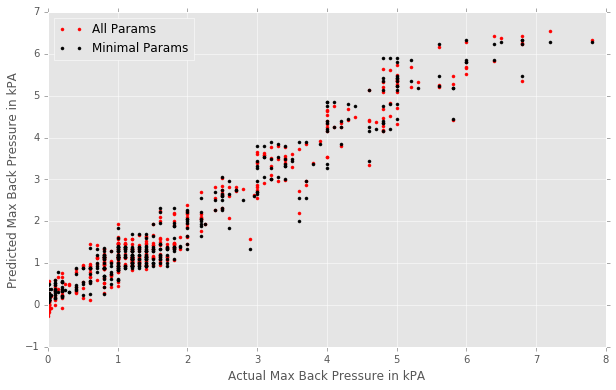

In [445]:

# select features and output parameters
test_col = ['Max Back Pressure in kPA']
feature_cols = ['Ball Infill','DST Length','SideStack Area','Mouthpiece Inlet Size','Max Flow in Waveform File']

# only use features where we have an output to predict
dftmp = df[~df[test_col[0]].isnull()]
dftmp = dftmp[feature_cols+test_col]

# clean up types
for col in feature_cols+test_col:
    dftmp[col] = dftmp[col].astype(np.float)
dftmp.info()

# create first regression and display importances
reg = linear_model.LinearRegression()
df_X = create_interaction_terms(dftmp[feature_cols])

yhat = reg.fit(df_X.values,dftmp[test_col[0]].values).predict(df_X.values)
scr = reg.score(df_X.values,dftmp[test_col[0]].values)

important_cols = show_regression_equation(df_X,reg,scr,1.7)

# create minimized regression
df_X_min = df_X[important_cols]
yhat_min = reg.fit(df_X_min.values,dftmp[test_col[0]].values).predict(df_X_min.values)
scr = reg.score(df_X_min.values,dftmp[test_col[0]].values)

reg_dict[test_col[0]] = (copy.deepcopy(reg),important_cols)

important_cols = show_regression_equation(df_X_min,reg,scr,-1)

# plot the results side by side
plt.figure(figsize=(10,6))
plt.plot(dftmp[test_col[0]].values,yhat,'r.',label='All Params')
plt.plot(dftmp[test_col[0]].values,yhat_min,'k.',label='Minimal Params')
plt.xlabel('Actual '+test_col[0])
plt.ylabel('Predicted '+test_col[0])
plt.legend(loc=2)

plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 9 to 416
Data columns (total 6 columns):
Ball Infill                              103 non-null float64
DST Length                               103 non-null float64
SideStack Area                           103 non-null float64
Mouthpiece Inlet Size                    103 non-null float64
Max Flow in Waveform File                103 non-null float64
Minimum Flow for Audible Vortex Start    103 non-null float64
dtypes: float64(6)
memory usage: 5.6 KB
---------------------------------
Linear Estimator R^2 = 0.598948771677  20 parameters
(intrcpt)	-0.196528869623
(2.06)		-0.000016297*SideStack Area-SideStack Area
(5.03)		-0.000142680*SideStack Area-Mouthpiece Inlet Size
(3.54)		-0.001004881*SideStack Area-Max Flow in Waveform File
(2.78)		-0.002876272*Mouthpiece Inlet Size-Max Flow in Waveform File
(1.56)		-0.006863740*DST Length-Max Flow in Waveform File
(7.19)		0.028607481*SideStack Area
(2.48)		0.039037690*Mouthpiece Inlet S

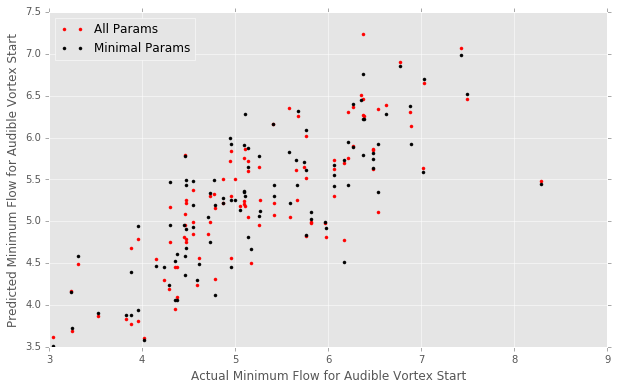

In [446]:
# select features and output parameters
test_col = ['Minimum Flow for Audible Vortex Start']
feature_cols = ['Ball Infill','DST Length','SideStack Area','Mouthpiece Inlet Size','Max Flow in Waveform File']

# only use features where we have an output to predict
dftmp = df[~df[test_col[0]].isnull()]
dftmp = dftmp[feature_cols+test_col]

# clean up types
for col in feature_cols+test_col:
    dftmp[col] = dftmp[col].astype(np.float)
dftmp.info()

# create first regression and display importances
reg = linear_model.LinearRegression()
df_X = create_interaction_terms(dftmp[feature_cols])

yhat = reg.fit(df_X.values,dftmp[test_col[0]].values).predict(df_X.values)
scr = reg.score(df_X.values,dftmp[test_col[0]].values)

important_cols = show_regression_equation(df_X,reg,scr,1.5)

# create minimized regression
df_X_min = df_X[important_cols]
yhat_min = reg.fit(df_X_min.values,dftmp[test_col[0]].values).predict(df_X_min.values)
scr = reg.score(df_X_min.values,dftmp[test_col[0]].values)

reg_dict[test_col[0]] = (copy.deepcopy(reg),important_cols)

important_cols = show_regression_equation(df_X_min,reg,scr,-1)

# plot the results side by side
plt.figure(figsize=(10,6))
plt.plot(dftmp[test_col[0]].values,yhat,'r.',label='All Params')
plt.plot(dftmp[test_col[0]].values,yhat_min,'k.',label='Minimal Params')
plt.xlabel('Actual '+test_col[0])
plt.ylabel('Predicted '+test_col[0])
plt.legend(loc=2)

plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 9 to 416
Data columns (total 6 columns):
Ball Infill                            103 non-null float64
DST Length                             103 non-null float64
SideStack Area                         103 non-null float64
Mouthpiece Inlet Size                  103 non-null float64
Max Flow in Waveform File              103 non-null float64
Minimum Flow for Audible Vortex End    103 non-null float64
dtypes: float64(6)
memory usage: 5.6 KB
---------------------------------
Linear Estimator R^2 = 0.646103346624  20 parameters
(intrcpt)	-2.8965447165
(2.70)		-0.000021372*SideStack Area-SideStack Area
(2.09)		-0.000059442*SideStack Area-Mouthpiece Inlet Size
(2.02)		-0.000235832*DST Length-SideStack Area
(4.51)		-0.000463293*Mouthpiece Inlet Size-Mouthpiece Inlet Size
(3.22)		-0.003331766*Mouthpiece Inlet Size-Max Flow in Waveform File
(2.88)		-0.005452072*DST Length-DST Length
(2.34)		0.010273380*DST Length-Max Flow in Waveform 

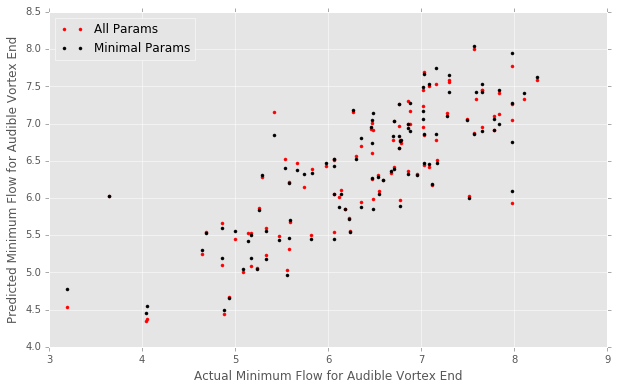

In [447]:
# select features and output parameters
test_col = ['Minimum Flow for Audible Vortex End']
feature_cols = ['Ball Infill','DST Length','SideStack Area','Mouthpiece Inlet Size','Max Flow in Waveform File']

# only use features where we have an output to predict
dftmp = df[~df[test_col[0]].isnull()]
dftmp = dftmp[feature_cols+test_col]

# clean up types
for col in feature_cols+test_col:
    dftmp[col] = dftmp[col].astype(np.float)
dftmp.info()

# create first regression and display importances
reg = linear_model.LinearRegression()
df_X = create_interaction_terms(dftmp[feature_cols])

yhat = reg.fit(df_X.values,dftmp[test_col[0]].values).predict(df_X.values)
scr = reg.score(df_X.values,dftmp[test_col[0]].values)

important_cols = show_regression_equation(df_X,reg,scr,2)

# create minimized regression
df_X_min = df_X[important_cols]
yhat_min = reg.fit(df_X_min.values,dftmp[test_col[0]].values).predict(df_X_min.values)
scr = reg.score(df_X_min.values,dftmp[test_col[0]].values)

reg_dict[test_col[0]] = (copy.deepcopy(reg),important_cols)
important_cols = show_regression_equation(df_X_min,reg,scr,-1)

# plot the results side by side
plt.figure(figsize=(10,6))
plt.plot(dftmp[test_col[0]].values,yhat,'r.',label='All Params')
plt.plot(dftmp[test_col[0]].values,yhat_min,'k.',label='Minimal Params')
plt.xlabel('Actual '+test_col[0])
plt.ylabel('Predicted '+test_col[0])
plt.legend(loc=2)

plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 420
Data columns (total 7 columns):
Ball Infill                                       135 non-null float64
DST Length                                        135 non-null float64
SideStack Area                                    135 non-null float64
Mouthpiece Inlet Size                             135 non-null float64
Max Flow in Waveform File                         135 non-null float64
Max Rise Time in Waveform File                    135 non-null float64
Time Difference between Ideal/Actual Max Flow     135 non-null float64
dtypes: float64(7)
memory usage: 8.4 KB
---------------------------------
Linear Estimator R^2 = 0.108846744283  27 parameters
(intrcpt)	0.170366036742
(0.26)		-0.000026376*Mouthpiece Inlet Size-Mouthpiece Inlet Size
(0.14)		0.000058944*DST Length-Mouthpiece Inlet Size
(0.28)		0.000117593*DST Length-Max Rise Time in Waveform File
(0.21)		0.000656550*Mouthpiece Inlet Size-Max Flow in Waveform File

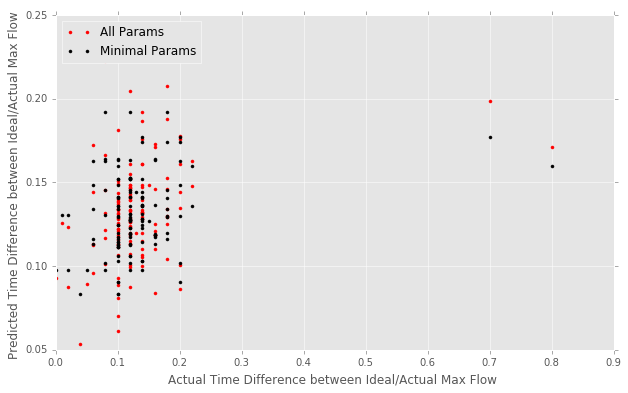

In [448]:
# select features and output parameters
test_col = ['Time Difference between Ideal/Actual Max Flow ']
feature_cols = ['Ball Infill','DST Length','SideStack Area','Mouthpiece Inlet Size',
                'Max Flow in Waveform File','Max Rise Time in Waveform File']

# only use features where we have an output to predict
dftmp = df[~df[test_col[0]].isnull()]
dftmp = dftmp[feature_cols+test_col]

# clean up types
for col in feature_cols+test_col:
    dftmp[col] = dftmp[col].astype(np.float)
dftmp.info()

# create first regression and display importances
reg = linear_model.LinearRegression()
df_X = create_interaction_terms(dftmp[feature_cols])

yhat = reg.fit(df_X.values,dftmp[test_col[0]].values).predict(df_X.values)
scr = reg.score(df_X.values,dftmp[test_col[0]].values)

reg_dict[test_col[0]] = (copy.deepcopy(reg),important_cols)
important_cols = show_regression_equation(df_X,reg,scr,0.1)

# create minimized regression
df_X_min = df_X[important_cols]
yhat_min = reg.fit(df_X_min.values,dftmp[test_col[0]].values).predict(df_X_min.values)
scr = reg.score(df_X_min.values,dftmp[test_col[0]].values)

important_cols = show_regression_equation(df_X_min,reg,scr,-1)

# plot the results side by side
plt.figure(figsize=(10,6))
plt.plot(dftmp[test_col[0]].values,yhat,'r.',label='All Params')
plt.plot(dftmp[test_col[0]].values,yhat_min,'k.',label='Minimal Params')
plt.xlabel('Actual '+test_col[0])
plt.ylabel('Predicted '+test_col[0])
plt.legend(loc=2)

plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 5 to 431
Data columns (total 6 columns):
Ball Infill                                          297 non-null float64
DST Length                                           297 non-null float64
SideStack Area                                       297 non-null float64
Mouthpiece Inlet Size                                297 non-null float64
Max Flow in Waveform File                            297 non-null float64
Difference between Ideal and Actual Max Flow Rate    297 non-null float64
dtypes: float64(6)
memory usage: 16.2 KB
---------------------------------
Linear Estimator R^2 = 0.669890644435  20 parameters
(intrcpt)	-0.0535715520161
(0.16)		-0.000310045*DST Length-DST Length
(0.27)		0.000914983*DST Length-Max Flow in Waveform File
(0.16)		0.013007366*DST Length
(0.18)		-0.017555479*Max Flow in Waveform File
---------------------------------
---------------------------------
Linear Estimator R^2 = 0.641557467239  4 parameters

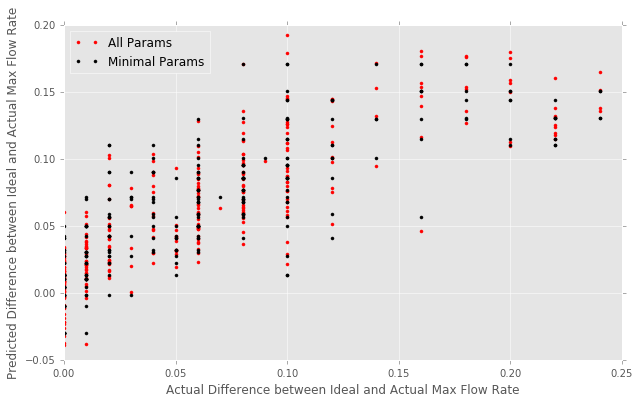

In [449]:
# select features and output parameters
test_col = ['Difference between Ideal and Actual Max Flow Rate']
feature_cols = ['Ball Infill','DST Length','SideStack Area','Mouthpiece Inlet Size',
                'Max Flow in Waveform File']

# only use features where we have an output to predict
dftmp = df[~df[test_col[0]].isnull()]
dftmp = dftmp[feature_cols+test_col]

# clean up types
for col in feature_cols+test_col:
    dftmp[col] = dftmp[col].astype(np.float)
dftmp.info()

# create first regression and display importances
reg = linear_model.LinearRegression()
df_X = create_interaction_terms(dftmp[feature_cols])

yhat = reg.fit(df_X.values,dftmp[test_col[0]].values).predict(df_X.values)
scr = reg.score(df_X.values,dftmp[test_col[0]].values)

important_cols = show_regression_equation(df_X,reg,scr,0.1)

# create minimized regression
df_X_min = df_X[important_cols]
yhat_min = reg.fit(df_X_min.values,dftmp[test_col[0]].values).predict(df_X_min.values)
scr = reg.score(df_X_min.values,dftmp[test_col[0]].values)

reg_dict[test_col[0]] = (copy.deepcopy(reg),important_cols)
important_cols = show_regression_equation(df_X_min,reg,scr,-1)

# plot the results side by side
plt.figure(figsize=(10,6))
plt.plot(dftmp[test_col[0]].values,yhat,'r.',label='All Params')
plt.plot(dftmp[test_col[0]].values,yhat_min,'k.',label='Minimal Params')
plt.xlabel('Actual '+test_col[0])
plt.ylabel('Predicted '+test_col[0])
plt.legend(loc=2)

plt.show()

In [450]:
reg_dict

{'Difference between Ideal and Actual Max Flow Rate': (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  ['DST Length-DST Length',
   'DST Length-Max Flow in Waveform File',
   'DST Length',
   'Max Flow in Waveform File']),
 'Max Back Pressure in kPA': (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  ['SideStack Area-Max Flow in Waveform File',
   'Max Flow in Waveform File-Max Flow in Waveform File',
   'DST Length']),
 'Minimum Flow for Audible Vortex End': (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  ['SideStack Area-SideStack Area',
   'SideStack Area-Mouthpiece Inlet Size',
   'DST Length-SideStack Area',
   'Mouthpiece Inlet Size-Mouthpiece Inlet Size',
   'Mouthpiece Inlet Size-Max Flow in Waveform File',
   'DST Length-DST Length',
   'DST Length-Max Flow in Waveform File',
   'SideStack Area',
   'Max Flow in Waveform File-Max Flow in Waveform File',
   'Mouthpiece Inlet Size',
 

In [451]:
# enumerate all the possible combinations and choose one with low BP and Low Flow On state
# for each combination, get the hypothesized values
# select features and output parameters
feature_cols = ['Ball Infill','DST Length','SideStack Area','Mouthpiece Inlet Size']

# only use features where we have an output to predict
dftmp = df_combo
dftmp = dftmp[feature_cols]

# clean up types
for col in feature_cols:
    dftmp[col] = dftmp[col].astype(np.float)
dftmp.info()

df_combo_manip = create_interaction_terms(dftmp)

df_combo_manip = df_combo.merge(df_combo_manip)

df_combo_manip.head()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 0 to 80
Data columns (total 4 columns):
Ball Infill              81 non-null float64
DST Length               81 non-null float64
SideStack Area           81 non-null float64
Mouthpiece Inlet Size    81 non-null float64
dtypes: float64(4)
memory usage: 3.2 KB


/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Combo,Ball,Downstream Tube,Sidestack,Mouthpiece,Ball Infill,DST Length,SideStack Area,Mouthpiece Inlet Size,Ball Infill-Ball Infill,Ball Infill-DST Length,Ball Infill-SideStack Area,Ball Infill-Mouthpiece Inlet Size,DST Length-DST Length,DST Length-SideStack Area,DST Length-Mouthpiece Inlet Size,SideStack Area-SideStack Area,SideStack Area-Mouthpiece Inlet Size,Mouthpiece Inlet Size-Mouthpiece Inlet Size
0,Combo 1,A (Blue),A (Blue),A (Red),A (Red),0,16,125.663706,45.00,0,0,0,0,256,2010.619298,720.00,15791.367031,5654.866775,2025.0000
1,Combo 2,A (Blue),A (Blue),A (Red),B (Green),0,16,125.663706,61.02,0,0,0,0,256,2010.619298,976.32,15791.367031,7667.999346,3723.4404
2,Combo 3,A (Blue),A (Blue),A (Red),C (Yellow),0,16,125.663706,108.45,0,0,0,0,256,2010.619298,1735.20,15791.367031,13628.228927,11761.4025
3,Combo 4,A (Blue),A (Blue),B (Green),A (Red),0,16,251.327412,45.00,0,0,0,0,256,4021.238597,720.00,63165.468173,11309.733554,2025.0000
4,Combo 5,A (Blue),A (Blue),B (Green),B (Green),0,16,251.327412,61.02,0,0,0,0,256,4021.238597,976.32,63165.468173,15335.998699,3723.4404


In [493]:
def get_whistle_configuration_for_PEF(PEF=8.0):
    df_combo_manip = df_combo

    df_combo_manip['Max Flow in Waveform File'] = PEF

    # enumerate all the possible combinations and choose one with low BP and Low Flow On state
    # for each combination, get the hypothesized values
    # select features and output parameters
    feature_cols = ['Ball Infill','DST Length','SideStack Area','Mouthpiece Inlet Size','Max Flow in Waveform File']

    # only use features where we have an output to predict
    dftmp = df_combo_manip
    dftmp = dftmp[feature_cols]

    # clean up types
    for col in feature_cols:
        dftmp[col] = dftmp[col].astype(np.float)
    
    # merge the data
    df_combo_manip = create_interaction_terms(dftmp)
    df_combo_manip = df_combo.merge(df_combo_manip)

    keys = ['Minimum Flow for Audible Vortex End',
     'Difference between Ideal and Actual Max Flow Rate',
     'Minimum Flow for Audible Vortex Start',
     'Max Back Pressure in kPA']
    for key in keys:
        cols = reg_dict[key][1]
        reg = reg_dict[key][0]
        X = df_combo_manip[cols].values
        yhat = reg.predict(X)

        df_combo_manip['pred.'+key] = yhat

    idx = np.argmin(df_combo_manip['pred.Minimum Flow for Audible Vortex Start']+df_combo_manip['pred.Minimum Flow for Audible Vortex End'])
    fVal = df_combo_manip['pred.Minimum Flow for Audible Vortex Start'].values[idx]
    #print fVal
    df_possible = df_combo_manip[(df_combo_manip['pred.Minimum Flow for Audible Vortex Start']<fVal+PEF/15.0) | 
                  (df_combo_manip['pred.Minimum Flow for Audible Vortex End']<fVal+PEF/15.0)]
        
    idx = np.argmin(df_possible['pred.Max Back Pressure in kPA'])
    return df_possible.loc[idx]

In [494]:
for PEF in np.linspace(6,14,20):
    dftmp = get_whistle_configuration_for_PEF(PEF)
    print '===================================='
    print 'If PEF is close to', PEF
    print dftmp.head().T

/Library/Python/2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


If PEF is close to 6.0
Combo               Combo 10
Ball                A (Blue)
Downstream Tube    B (Green)
Sidestack            A (Red)
Mouthpiece           A (Red)
Name: 9, dtype: object
If PEF is close to 6.42105263158
Combo               Combo 10
Ball                A (Blue)
Downstream Tube    B (Green)
Sidestack            A (Red)
Mouthpiece           A (Red)
Name: 9, dtype: object
If PEF is close to 6.84210526316
Combo               Combo 10
Ball                A (Blue)
Downstream Tube    B (Green)
Sidestack            A (Red)
Mouthpiece           A (Red)
Name: 9, dtype: object
If PEF is close to 7.26315789474
Combo               Combo 10
Ball                A (Blue)
Downstream Tube    B (Green)
Sidestack            A (Red)
Mouthpiece           A (Red)
Name: 9, dtype: object
If PEF is close to 7.68421052632
Combo                 Combo 9
Ball                 A (Blue)
Downstream Tube      A (Blue)
Sidestack          C (Yellow)
Mouthpiece         C (Yellow)
Name: 8, dtype: object


/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


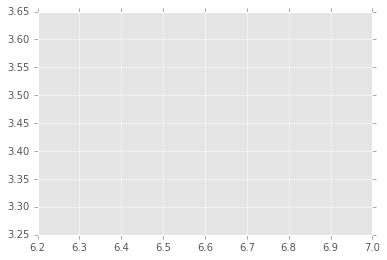

In [454]:
plt.plot(dftmp['pred.Minimum Flow for Audible Vortex End'],dftmp['pred.Max Back Pressure in kPA'])